# 05 — Training Monitor Dashboard

Extract and visualize all training metrics from `trainer_state.json` across checkpoints.

**Metrics:**
- Training Loss (smoothed)
- Gradient Norm (stability)
- Learning Rate (schedule)
- Loss improvement rate
- Convergence detection

In [27]:
# Cell 1: Imports
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress
import warnings
warnings.filterwarnings('ignore')

In [28]:
# Cell 2: Config & Load Data
project_root = Path('..').resolve()
outputs_dir = project_root / 'outputs'

# You can change this to 'dora_runs' or 'good-enough' to compare different runs
run_name = 'dora-optimised-1k'
run_path = outputs_dir / 'good-enough' / 'optimised-1k' / 'checkpoint-125'

print(f"📁 Loading from: {run_path}")
print(f"Available runs: {[d.name for d in outputs_dir.iterdir() if d.is_dir()]}")

📁 Loading from: C:\Users\a\Desktop\other SHIET\fine-poems\outputs\good-enough\optimised-1k\checkpoint-125
Available runs: ['dora_runs', 'good-enough', 'judge_arena', 'lora_runs']


In [29]:
# Cell 3: Load metrics from latest checkpoint
def extract_training_metrics(run_path, exact=False):
    """
    Load log_history from latest checkpoint's trainer_state.json.
    Latest checkpoint contains all prior training steps.
    """
    if exact:
        if not run_path.exists():
            raise ValueError(f"Checkpoint directory {run_path} does not exist.")
        state_file = run_path / 'trainer_state.json'
    else:
        checkpoints = sorted([d for d in run_path.iterdir() if d.is_dir() and d.name.startswith('checkpoint-')])
        
        if not checkpoints:
            raise ValueError(f"No checkpoints found in {run_path}")
        
        # Use only the latest checkpoint
        latest_checkpoint = checkpoints[-1]
        state_file = latest_checkpoint / 'trainer_state.json'
    
    with open(state_file, 'r') as f:
        state = json.load(f)
    
    # Create DataFrame from log_history
    df = pd.DataFrame(state.get('log_history', []))
    
    # Keep only rows with 'step' and 'loss' (skip validation-only rows)
    df = df[df['step'].notna() & df['loss'].notna()].drop_duplicates(subset=['step']).reset_index(drop=True)
    df = df.sort_values('step').reset_index(drop=True)
    
    return df

metrics_df = extract_training_metrics(run_path, exact=True)
# metrics_df = extract_training_metrics(run_path)
print(f"\n✅ Extracted {len(metrics_df)} training steps")
print(f"\nMetrics available: {list(metrics_df.columns)}")
print(f"\nData preview:")
print(metrics_df.head(10))


✅ Extracted 25 training steps

Metrics available: ['epoch', 'grad_norm', 'learning_rate', 'loss', 'step', 'eval_loss', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second']

Data preview:
   epoch  grad_norm  learning_rate    loss  step  eval_loss  eval_runtime  \
0   0.04   2.602922       0.000200  2.5546     5        NaN           NaN   
1   0.08   1.143859       0.000450  1.2228    10        NaN           NaN   
2   0.12  16.378298       0.000499  1.0566    15        NaN           NaN   
3   0.16  10.640544       0.000492  1.8178    20        NaN           NaN   
4   0.20   4.710704       0.000482  1.8347    25        NaN           NaN   
5   0.24   3.145295       0.000467  1.5623    30        NaN           NaN   
6   0.28   2.445213       0.000448  1.2641    35        NaN           NaN   
7   0.32   1.113016       0.000426  1.0840    40        NaN           NaN   
8   0.36  61.600056       0.000400  1.3478    45        NaN           NaN   
9   0.40  26.350744       0

In [30]:
# Cell 4: Compute derived metrics
# Loss improvement per step
metrics_df['loss_delta'] = metrics_df['loss'].diff()
metrics_df['loss_delta_pct'] = (metrics_df['loss'].pct_change() * 100)

# Smoothed loss (for trend detection)
metrics_df['loss_smoothed'] = gaussian_filter1d(metrics_df['loss'], sigma=10)

# Learning rate in scientific notation
metrics_df['lr_magnitude'] = -np.log10(metrics_df['learning_rate'])

print("✓ Derived metrics computed")
print(f"\nComputed columns: loss_delta, loss_delta_pct, loss_smoothed, lr_magnitude")

✓ Derived metrics computed

Computed columns: loss_delta, loss_delta_pct, loss_smoothed, lr_magnitude


In [31]:
# Cell 5: Summary Statistics
print("\n" + "="*60)
print("📊 TRAINING SUMMARY")
print("="*60)

metrics = {
    'Total Steps': int(metrics_df['step'].max()),
    'Initial Loss': f"{metrics_df['loss'].iloc[0]:.4f}",
    'Final Loss': f"{metrics_df['loss'].iloc[-1]:.4f}",
    'Min Loss': f"{metrics_df['loss'].min():.4f} @ Step {int(metrics_df.loc[metrics_df['loss'].idxmin(), 'step'])}",
    'Max Loss': f"{metrics_df['loss'].max():.4f}",
    'Loss Improvement': f"{(metrics_df['loss'].iloc[0] - metrics_df['loss'].iloc[-1]):.4f} ({(1 - metrics_df['loss'].iloc[-1]/metrics_df['loss'].iloc[0])*100:.1f}%)",
}

for key, val in metrics.items():
    print(f"  {key:<25} {val}")

# Gradient norm stats
if 'grad_norm' in metrics_df.columns:
    print(f"\n  Gradient Norm (avg)      {metrics_df['grad_norm'].mean():.4f}")
    print(f"  Gradient Norm (max)      {metrics_df['grad_norm'].max():.4f}")
    print(f"  Exploding Gradients?     {'⚠️  YES (>100)' if metrics_df['grad_norm'].max() > 100 else '✓ No'}")

print("\n" + "="*60)


📊 TRAINING SUMMARY
  Total Steps               125
  Initial Loss              2.5546
  Final Loss                0.7991
  Min Loss                  0.7593 @ Step 110
  Max Loss                  2.5546
  Loss Improvement          1.7555 (68.7%)

  Gradient Norm (avg)      6.4627
  Gradient Norm (max)      61.6001
  Exploding Gradients?     ✓ No



In [32]:
# Cell 6: Learning Rate Schedule
print("\n📈 LEARNING RATE\n")

lr_at_end = metrics_df['learning_rate'].iloc[-1]
lr_at_start = metrics_df['learning_rate'].iloc[0]

print(f"  Initial LR:              {lr_at_start:.2e}")
print(f"  Final LR:                {lr_at_end:.2e}")
print(f"  Total Decay:             {(1 - lr_at_end/lr_at_start)*100:.1f}%")


📈 LEARNING RATE

  Initial LR:              2.00e-04
  Final LR:                9.33e-08
  Total Decay:             100.0%


In [33]:
# Cell 7: Detection - Convergence & Plateau
print("\n🎯 CONVERGENCE ANALYSIS\n")

# Last 10% of training
last_n = max(100, len(metrics_df) // 10)
last_segment = metrics_df.iloc[-last_n:]

# Slope of loss in final segment
x_last = np.array(last_segment['step'].values - last_segment['step'].values[0])
y_last = np.array(last_segment['loss'].values)
slope, intercept, r_value, p_value, std_err = linregress(x_last, y_last)

print(f"  Last {last_n} steps (final {(last_n/len(metrics_df)*100):.1f}% of training):")
print(f"    - Loss slope:          {slope:.2e} per step")
print(f"    - Avg loss:            {y_last.mean():.4f}")
print(f"    - Std of loss:         {y_last.std():.4f}")
print(f"    - R²:                  {r_value**2:.4f} (fit quality)")

if abs(slope) < 0.0001:
    print(f"\n  ✓ Model has CONVERGED (loss plateau detected)")
else:
    print(f"\n  ⚠️  Model still improving (slope = {slope:.2e})")


🎯 CONVERGENCE ANALYSIS

  Last 100 steps (final 400.0% of training):
    - Loss slope:          -9.36e-03 per step
    - Avg loss:            1.1493
    - Std of loss:         0.4388
    - R²:                  0.5913 (fit quality)

  ⚠️  Model still improving (slope = -9.36e-03)


✓ Dashboard saved to training_metrics_dashboard.png
  Best eval_loss: 0.7767 at step 120


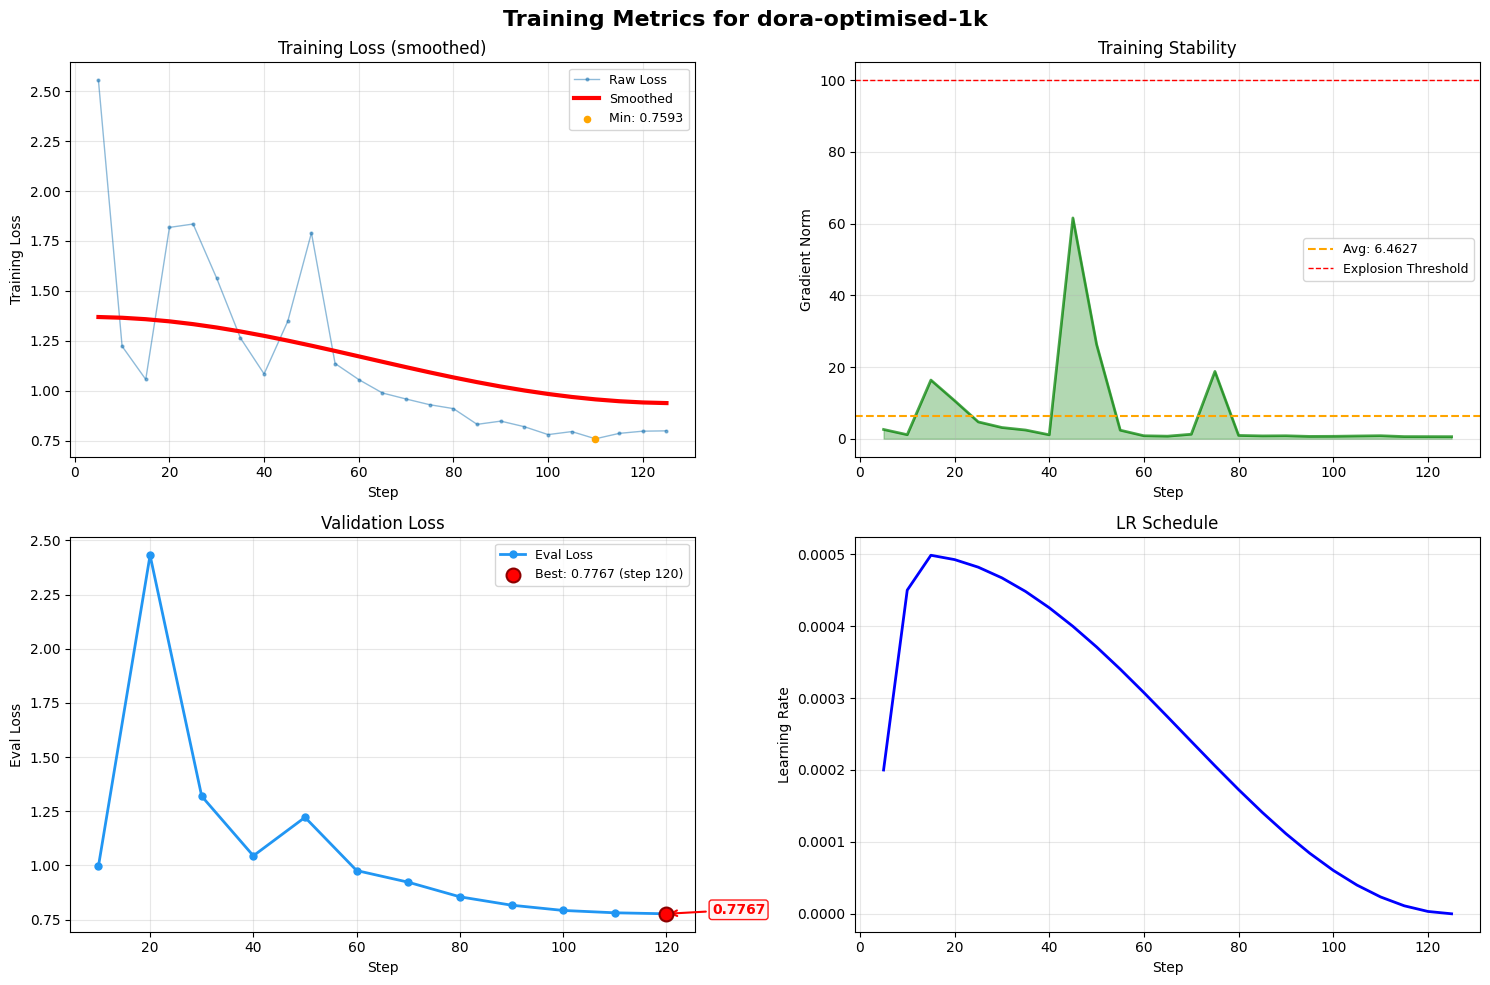

In [34]:
# Cell 8: Multi-metric Visualization (4-panel grid)
# Layout: Left column = losses (vertically aligned), Right column = stability metrics

# --- Load eval data ---
with open(run_path / 'trainer_state.json', 'r') as f:
    _state = json.load(f)
eval_df = pd.DataFrame([e for e in _state.get('log_history', []) if 'eval_loss' in e])

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Training Metrics for {run_name}', fontsize=16, fontweight='bold')

# Panel 1 (top-left): Training Loss + Smoothed
ax = axes[0, 0]
ax.plot(metrics_df['step'], metrics_df['loss'], 'o-', linewidth=1, markersize=2, alpha=0.5, label='Raw Loss')
ax.plot(metrics_df['step'], metrics_df['loss_smoothed'], linewidth=3, color='red', label='Smoothed')
min_idx = metrics_df['loss'].idxmin()
ax.scatter(metrics_df.loc[min_idx, 'step'], metrics_df.loc[min_idx, 'loss'], 
          color='orange', s=20, zorder=5, label=f'Min: {metrics_df.loc[min_idx, "loss"]:.4f}')
ax.set_xlabel('Step')
ax.set_ylabel('Training Loss')
ax.set_title('Training Loss (smoothed)')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 2 (top-right): Gradient Norm
ax = axes[0, 1]
if 'grad_norm' in metrics_df.columns:
    ax.plot(metrics_df['step'], metrics_df['grad_norm'], 'g-', linewidth=2, alpha=0.7)
    ax.fill_between(metrics_df['step'], metrics_df['grad_norm'], alpha=0.3, color='green')
    ax.axhline(y=metrics_df['grad_norm'].mean(), color='orange', linestyle='--', 
               label=f'Avg: {metrics_df["grad_norm"].mean():.4f}')
    ax.axhline(y=100, color='red', linestyle='--', linewidth=1, label='Explosion Threshold')
    ax.set_ylabel('Gradient Norm')
    ax.set_title('Training Stability')
    ax.legend(fontsize=9)
else:
    ax.text(0.5, 0.5, 'No gradient norm data', ha='center', va='center')
    ax.set_title('Gradient Norm (N/A)')
ax.set_xlabel('Step')
ax.grid(True, alpha=0.3)

# Panel 3 (bottom-left): Validation Loss — vertically aligned with training loss
ax = axes[1, 0]
if not eval_df.empty:
    ax.plot(eval_df['step'], eval_df['eval_loss'], 'o-', linewidth=2, markersize=5,
            color='#2196F3', label='Eval Loss')
    e_min_idx = eval_df['eval_loss'].idxmin()
    e_min_step = eval_df.loc[e_min_idx, 'step']
    e_min_loss = eval_df.loc[e_min_idx, 'eval_loss']
    ax.scatter(e_min_step, e_min_loss, color='red', s=100, zorder=5,
               edgecolors='darkred', linewidths=1.5,
               label=f'Best: {e_min_loss:.4f} (step {int(e_min_step)})')
    ax.annotate(f'{e_min_loss:.4f}', xy=(e_min_step, e_min_loss),
                xytext=(e_min_step + (eval_df['step'].max() - eval_df['step'].min()) * 0.08, e_min_loss),
                fontsize=10, fontweight='bold', color='red',
                arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                bbox=dict(boxstyle='round,pad=0.2', facecolor='#fff3f3', edgecolor='red', alpha=0.9))
    ax.set_ylabel('Eval Loss')
    ax.set_title('Validation Loss')
    ax.legend(fontsize=9)
else:
    ax.text(0.5, 0.5, 'No eval_loss entries found', ha='center', va='center', fontsize=12)
    ax.set_title('Validation Loss (N/A)')
ax.set_xlabel('Step')
ax.grid(True, alpha=0.3)

# Panel 4 (bottom-right): Learning Rate Schedule
ax = axes[1, 1]
ax.plot(metrics_df['step'], metrics_df['learning_rate'], 'b-', linewidth=2)
ax.set_xlabel('Step')
ax.set_ylabel('Learning Rate')
ax.set_title('LR Schedule')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'training_metrics_dashboard.png', dpi=450, bbox_inches='tight')
print("✓ Dashboard saved to training_metrics_dashboard.png")
if not eval_df.empty:
    print(f"  Best eval_loss: {e_min_loss:.4f} at step {int(e_min_step)}")
plt.show()